## Description

- The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies

Evaluated by Root Mean Squared Error (RMSE)

## Data Fields
- **fullVisitorId **- A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping ** - The channel via which the user came to the Store.
- **date ** - The date on which the user visited the Store.
- **device ** - The specifications for the device used to access the Store.
- **geoNetwork ** - This section contains information about the geography of the user.
- **socialEngagementType ** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals ** - This section contains aggregate values across the session.
- **trafficSource ** - This section contains information about the Traffic Source from which the session originated.
- **visitId ** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber ** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime ** - The timestamp (expressed as POSIX time).
- **hits ** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- **customDimensions ** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- **totals ** - This set of columns mostly includes high-level aggregate data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score

import json
from pandas.io.json import json_normalize

import pickle

## Loading Data Frame

In [3]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {csv_path}. Shape: {df.shape}")
    return df

In [4]:
#df_train = load_df()

#df_train.to_pickle("proceed_data_v2.pkl")

In [3]:
df_test = pd.read_pickle("test_data.pkl")

In [2]:
df_train = pd.read_csv("Not_clean_without_hits.csv")

/Users/JasonLi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train = df_train.drop(['Unnamed: 0'],axis = 1)

In [4]:
df_train['fullVisitorId'] = df_train['fullVisitorId'].apply(lambda x: str(x))

In [5]:
len(df_train["fullVisitorId"].unique())

1328519

In [4]:
df_test['fullVisitorId'] = df_test['fullVisitorId'].apply(lambda x: str(x))

In [5]:
len(df_test["fullVisitorId"].unique())

296530

## EDA

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 58 columns):
channelGrouping                                      object
date                                                 int64
fullVisitorId                                        object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                      bool
device.language                                      object
device.mobileDeviceBranding                          

In [7]:
df_train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


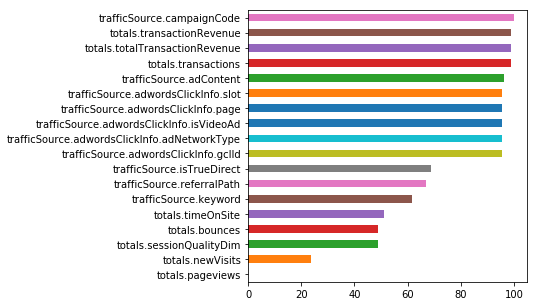

In [8]:
#Finding missing Data
MissChart = df_train.isnull().sum()/df_train.shape[0] *100
MissChart[MissChart >0].sort_values(ascending=True).plot(kind='barh', figsize = (5,5))

In [6]:
#Import Necessary Package
from sklearn.preprocessing import Imputer # Replace missing data values
from sklearn.preprocessing import LabelEncoder #encode the string accident causes into categorical numbers for later grouping
from datetime import datetime


In [7]:
def clean_data_df(data):
    for column in data:
        #Removing Data that only contains one unique value
        if len(data[column].value_counts())  == 1:
            data = data.drop(columns = column)
    
    data = data.drop(["trafficSource.adContent","trafficSource.adwordsClickInfo.slot",\
                    "trafficSource.adwordsClickInfo.page",\
                      "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId",\
                    "trafficSource.keyword","trafficSource.campaign"\
                    ,"trafficSource.medium","geoNetwork.metro","geoNetwork.networkDomain"\
                    ,"trafficSource.referralPath","geoNetwork.city","geoNetwork.metro"\
                    ,"geoNetwork.continent","geoNetwork.region","geoNetwork.country",\
                      "device.isMobile","totals.transactionRevenue","totals.transactions"],axis=1) 
    return data

In [11]:
df_train = clean_data_df(df_train)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 16 columns):
channelGrouping                   object
date                              int64
fullVisitorId                     object
visitId                           int64
visitNumber                       int64
visitStartTime                    int64
device.browser                    object
device.deviceCategory             object
device.operatingSystem            object
geoNetwork.subContinent           object
totals.hits                       int64
totals.pageviews                  float64
totals.sessionQualityDim          float64
totals.timeOnSite                 float64
totals.totalTransactionRevenue    float64
trafficSource.source              object
dtypes: float64(4), int64(5), object(7)
memory usage: 208.5+ MB


In [8]:
df_test = clean_data_df(df_test)

In [10]:
df_test = df_test.drop('customDimensions',axis =1)

In [11]:
def revenue_fun(x):
    x = int(x)
    if x !=0:
        return np.log(x)
    else:
        x = 0
        return x

In [12]:
def revenuelabel(x):
    if x == 0:
        x = 0
        return x
    else:
        x = 1
        return x

In [13]:
def cat_timehour(x):
    if x <= 12:
        return "Morn"
    else:
        return "Even"

In [14]:
def tranform_data(data):
    
    #Filling missing data in Pageviews
    DatapageNan = data[~data["totals.pageviews"].notna()]
    Datapage = data[data["totals.pageviews"].notna()]

    Datapage["totals.pageviews"] = Datapage["totals.pageviews"].apply(lambda x: int(x))
    median = Datapage["totals.pageviews"].median()
    DatapageNan["totals.pageviews"].fillna(median,inplace = True)
    
    
    frames = [Datapage,DatapageNan]
    data = pd.concat(frames)
    
    median = data["totals.sessionQualityDim"].median()
    data["totals.sessionQualityDim"].fillna(median,inplace = True)
    data["totals.hits"] = data["totals.hits"].apply(lambda x: int(x))
    
    #Date and Session time
    data['date'] = data['date'].apply(lambda x: dt.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
    data['visitStartTime'] = pd.to_datetime(data['visitStartTime'],unit='s', errors='coerce')

    data['totals.timeOnSite'] = data['totals.timeOnSite'].fillna(1)
    
    #Taking the log
    
    values = {'totals.totalTransactionRevenue': 0}
    data.fillna(value=values,inplace = True)
    data['totals.totalTransactionRevenue'] = data['totals.totalTransactionRevenue'].apply(lambda x: int(x))
    data['transactionRevenueLog'] = data['totals.totalTransactionRevenue'].apply(lambda x: revenue_fun(x))
    
    #Adding label for classifying whether or not customer will spend money in the store
    data['Revenue_label'] = data['totals.totalTransactionRevenue'].apply(lambda x: revenuelabel(x))
    
    #Renaming
    data.rename(columns = {"totals.pageviews":"pageviews", "device.browser":"browser",\
                            "device.deviceCategory": "deviceCategory",\
                            "device.operatingSystem": "OS","geoNetwork.subContinent":"subContinent",\
                           "totals.sessionQualityDim":"sessionQualityDim",\
                            "trafficSource.source":"source", "totals.totalTransactionRevenue":"Revenue_Original",\
                           "totals.hits":"hits", "totals.timeOnSite": "timeonsite"},inplace = True)
    
    data['month_year'] = pd.to_datetime(data['visitStartTime']).dt.to_period('M')
    data['month'] = data['visitStartTime'].dt.month
    data['year'] = data['visitStartTime'].dt.year
    #Time of the Day
    data['hourofday'] =  data['visitStartTime'].dt.hour
    data['timeofday'] = data['hourofday'].apply(lambda x: cat_timehour(x))
    
    data['timeofweek'] = data['visitStartTime'].dt.weekday_name
    data['day'] = data['visitStartTime'].dt.day
    
    
    return data


In [17]:
df_train2 = tranform_data(df_train)

/Users/JasonLi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/JasonLi/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
df_test2 = tranform_data(df_test)

/Users/JasonLi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/JasonLi/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [18]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 1701301
Data columns (total 23 columns):
channelGrouping          object
date                     object
fullVisitorId            object
visitId                  int64
visitNumber              int64
visitStartTime           datetime64[ns]
browser                  object
deviceCategory           object
OS                       object
subContinent             object
hits                     int64
pageviews                float64
sessionQualityDim        float64
timeonsite               float64
Revenue_Original         int64
source                   object
transactionRevenueLog    float64
Revenue_label            int64
month_year               object
hourofday                int64
timeofday                object
timeofweek               object
day                      int64
dtypes: datetime64[ns](1), float64(4), int64(7), object(11)
memory usage: 312.8+ MB


In [19]:
df_train2.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,browser,deviceCategory,OS,subContinent,...,timeonsite,Revenue_Original,source,transactionRevenueLog,Revenue_label,month_year,hourofday,timeofday,timeofweek,day
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,2017-10-17 00:00:50,Firefox,desktop,Windows,Western Europe,...,1.0,0,google,0.0,0,2017-10,0,Morn,Tuesday,17
1,Referral,2017-10-16,8934116514970143966,1508176307,6,2017-10-16 17:51:47,Chrome,desktop,Chrome OS,Northern America,...,28.0,0,sites.google.com,0.0,0,2017-10,17,Even,Monday,16
2,Direct,2017-10-16,7992466427990357681,1508201613,1,2017-10-17 00:53:33,Chrome,mobile,Android,Northern America,...,38.0,0,(direct),0.0,0,2017-10,0,Morn,Tuesday,17
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,2017-10-16 16:04:11,Chrome,desktop,Windows,Western Asia,...,1.0,0,google,0.0,0,2017-10,16,Even,Monday,16
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,2017-10-16 21:49:12,Chrome,desktop,Windows,Central America,...,52.0,0,google,0.0,0,2017-10,21,Even,Monday,16


In [20]:
df_train2.to_pickle("Data_Wrangling.pkl")

In [16]:
df_test2.to_pickle("Data_Wrangling_test.pkl")